In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

`Path.cwd()` will default to the top of the project directory, if the JupyterLab server was started from there.

In [4]:
data_folder = Path.cwd() / '..' / 'data'
catalog_folder = data_folder / 'catalog'
catalog_file = catalog_folder / 'full.csv'

output_file = data_folder / 'eligible_works.txt'

In [5]:
catalog = pd.read_csv(catalog_file)

Convert text columns into useful types

In [6]:
catalog.title = catalog.title.str.replace("(\r\n|\n)", ": ") # remove unnecessary newlines
catalog.published = pd.to_datetime(catalog.published) # convert to datetime objects
catalog.language = catalog.language.astype('category') # convert to categories
catalog.book = catalog.book.str.split('/').str.get(-1).astype('int64') # extract id number and convert to integer

In [7]:
catalog.head()

,book,title,published,language,author,subject
0,5356,The Inside of the Cup — Volume 01,2004-10-17,en,"Churchill, Winston",Attitude change -- Fiction
1,5356,The Inside of the Cup — Volume 01,2004-10-17,en,"Churchill, Winston",Christian life -- Fiction
2,5356,The Inside of the Cup — Volume 01,2004-10-17,en,"Churchill, Winston",Christian ethics -- Fiction
3,5356,The Inside of the Cup — Volume 01,2004-10-17,en,"Churchill, Winston",Conscience -- Religious aspects -- Fiction
4,5356,The Inside of the Cup — Volume 01,2004-10-17,en,"Churchill, Winston",PS


The catalog dataframe contains many duplicated fields at this point. In particular
 - `subject` has many values for each book, multiple genres
 - `author`, can have multiple values when several authors collaborated
 - `language`, as the book can be translated to different language

To extract the duplicated fields, we will put them in separate data frame, all of them indexed by the same `book` field.

In [8]:
raw_subjects = catalog[['book', 'subject']].drop_duplicates()
languages = catalog[['book', 'language']].drop_duplicates()
authors = catalog[['book', 'author']].drop_duplicates()
works = catalog[['book', 'title', 'published']].drop_duplicates()

Another issue that arises is the range of `published` dates. All of the dates are from after 1970, despite the fact that many of the books were created long before that date. It seems the the `published` field is actually tied to the physical publishing of the book, not the creation.

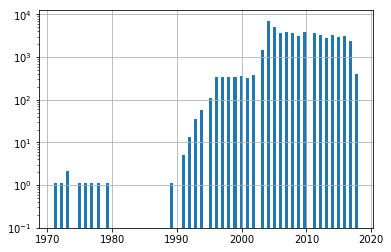

In [11]:
fig, ax = plt.subplots()
works.published.dt.year.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

Then instead of trying to predict published date by the text, we will attempt to predict the subject or genre of the work.

First we must process the subjects dataframe to extract more relevant information.

In [12]:
SUBJECT_MAPPINGS = {
    'AC': 'Collections, Series, Collected works',
    'AE': 'Encyclopedias',
    'AG': 'Dictionaries and other general reference works (other than Encyclopedias)',
    'AI': 'Indexes',
    'AM': 'Museums',
    'AN': 'Newspapers',
    'AP': 'Periodicals',
    'AS': 'Societies, Academies',
    'AY': 'Yearbooks, Almanacs, Directories',
    'AZ': 'General history of scholarship and learning',
    'BC': 'Logic',
    'BD': 'Speculative philosophy',
    'BF': 'Psychology',
    'BH': 'Aesthetics',
    'BJ': 'Ethics',
    'BL': 'Religions, Mythology, Rationalism, Hinduism',
    'BM': 'Judaism',
    'BP': 'Islam, Bahai Faith',
    'BQ': 'Buddhism',
    'BR': 'Christianity',
    'BS': 'Bible and exegesis',
    'BT': 'Doctrinal theology',
    'BV': 'Practical theology',
    'BX': 'Christian Denominations',
    'CB': 'History of Civilization (General and general special only)',
    'CC': 'Archaeology',
    'CD': 'Diplomatics, Archives, Seals',
    'CE': 'Technical Chronology, Calendar',
    'CJ': 'Numismatics (Coins, Tokes, Medals, Medallions)',
    'CN': 'Inscriptions, Epigraphy',
    'CR': 'Heraldry',
    'CS': 'Genealogy',
    'CT': 'Biography',
    'DA': 'Great Britain',
    'DAW': 'Central Europe',
    'DB': 'History of Austria, Austro-Hungarian Empire',
    'DC': 'France, Andorra, Monaco',
    'DD': 'Germany',
    'DE': 'Greco-Roman World',
    'DF': 'Greece',
    'DG': 'Italy – Malta',
    'DH': 'Low countries, Benelux Countries (Belgium, Luxembourg)',
    'DJ': 'Netherlands (Holland)',
    'DJK': 'Eastern Europe (General)',
    'DK': 'Russia, Soviet Union, Former Soviet Republics, Poland',
    'DL': 'Northern Europe, Scandinavia',
    'DP': 'Spain, Portugal',
    'DQ': 'Switzerland',
    'DR': 'Balkan Peninsula',
    'DS': 'Asia',
    'DT': 'Africa',
    'DU': 'Oceania (South Seas - Australia, New Zealand, Polynesia)',
    'DX': 'Gypsies',
    'GN': 'Anthropology',
    'GR': 'Folklore',
    'GT': 'Manners and customs (general)',
    'GV': 'Recreation, Leisure',
    'HA': 'Statistics',
    'HB': 'Economic theory, Demography',
    'HC': 'Economic history and conditions',
    'HD': 'Industries, Land use, Labor',
    'HE': 'Transportation and communications',
    'HF': 'Commerce (including tariff)',
    'HG': 'Finance ',
    'HJ': 'Public Finance',
    'HM': 'Sociology (General)',
    'HN': 'Social history and conditions, Social problems, Social reform',
    'HQ': 'Sexual Life, Family, Marriage, Women',
    'HS': 'Societies: secret, benevolent, etc.',
    'HT': 'Communities, Classes, Races',
    'HV': 'Social Pathology, Social and public welfare, Criminology',
    'HX': 'Socialism, Communism, Anarchism',
    'JA': 'Political Science (general)',
    'JC': 'Political theory',
    'JK': 'Polical institutions and public adminsitration - United States',
    'JL': 'Political institutions and public adminstration - America outside U.S.',
    'JN': 'Political Institutions and public administration – Europe',
    'JQ': 'Political institutions and public administration - Asia, Africa, Australia, Oceania',
    'JS': 'Local government. Municipal government.',
    'JV': 'Colonies and colonization. Emigration and immigration. International migration',
    'JX': 'International Law (See also KZ for International Law)',
    'JZ': 'International relations',
    'KBM': 'Jewish law',
    'KBP': 'Isamic law',
    'KBR': 'History of canon law',
    'KBU': 'Law of the Roman Catholic Church',
    'KDZ': 'America. North America',
    'KE': 'Canada',
    'KF': 'United States',
    'KG': 'Latin America, Mexico and Central America, West Indies, Caribbean area',
    'KH': 'South America',
    'KZ': 'Law of nations',
    'LA': 'History of Education',
    'LB': 'Theory and practice of education',
    'LC': 'Special aspects of education',
    'LD': 'Individual institutions - United States',
    'LE': 'Individual institutions - America outside of U.S.',
    'LF': 'Individual institutions - Europe',
    'LG': 'Individual institutions - Asia, Africa, Oceania',
    'LH': 'College and school magazines and papers',
    'LJ': 'Student fraternities and societies, United States',
    'LT': 'Textbooks',
    'ML': 'Literature of Music ',
    'MT': 'Musical instruction and study',
    'NA': 'Architexture',
    'NB': 'Sculpture',
    'NC': 'Drawing, Design, Illustration',
    'ND': 'Painting',
    'NE': 'Print Media',
    'NK': 'Decorative arts',
    'NX': 'Arts in general',
    'PA': 'Greek and Latin language and literature',
    'PB': 'Modern languages. Celtic languages',
    'PC': 'Romantic languages',
    'PD': 'Germanic, Scandinavian laguages.',
    'PE': 'English language',
    'PF': 'West Germanic Languages',
    'PG': 'Slavic, Baltic, Albanian languages.',
    'PH': 'Uralic, Basque languages ',
    'PJ': 'Oriental languages and literatures',
    'PK': 'Indo-Iranian languages and literatures',
    'PL': 'Languages and literatures of Eastern Asia, Africa, Oceania ',
    'PM': 'Hyperborean, Indian, and artificial languages',
    'PN': 'Literature - General',
    'PQ': 'French, Italian, Spanish, and Portuguese literature',
    'PR': 'Engish literature',
    'PS': 'American literature',
    'PT': 'German literature',
    'PZ': 'Fiction and juvenile literature',
    'QA': 'Mathematics',
    'QB': 'Astronomy',
    'QC': 'Physics',
    'QD': 'Chemistry',
    'QE': 'Geology',
    'QH': 'Natural History - Biology ',
    'QK': 'Botany',
    'QL': 'Zoology',
    'QM': 'Human anatomy',
    'QP': 'Physiology',
    'QR': 'Microbiology',
    'RA': 'Public aspects of medicine',
    'RB': 'Pathology',
    'RC': 'Internal Medicine',
    'RD': 'Surgery',
    'RE': 'Ophthalmology',
    'RF': 'Otorhinolaryngology (Ear, Nose, Throat)',
    'RG': 'Gynecology and obstetrics',
    'RJ': 'Pediatrics',
    'RK': 'Dentistry',
    'RL': 'Dermatology',
    'RM': 'Therapeutics. Pharmacology',
    'RS': 'Pharmacy and materia medica',
    'RT': 'Nursing',
    'RV': 'Botanic, Thomsonian, and Eclectic Medicine',
    'RX': 'Homeopathy',
    'RZ': 'Other systems of medicine',
    'SB': 'Plant culture',
    'SD': 'Forestry',
    'SF': 'Animal culture',
    'SH': 'Aquaculture. Fisheries, Angling',
    'SK': 'Hunting sports',
    'TA': 'General engineering',
    'TC': 'Hydraulic and ocean engineering.',
    'TD': 'Environmental technology, Sanitary engineering',
    'TE': 'Highway engineering (roads and pavements)',
    'TF': 'Railroad engineering and operation',
    'TG': 'Bridge engineering',
    'TH': 'Building construction',
    'TJ': 'Mechanical engineering and machinery',
    'TK': 'Electrical engineering, Electronics, Nuclear engineering',
    'TL': 'Motor vehicles, Aeronautics, Astronautics',
    'TN': 'Mining engineering, Metallurgy',
    'TP': 'Chemical technology',
    'TR': 'Photography',
    'TS': 'Manufactures',
    'TT': 'Handicrafts and Arts & Crafts',
    'TX': 'Home economics',
    'UA': 'Organization, distrubution, military situation',
    'UB': 'Military administration',
    'UC': 'Maintenance and transporation',
    'UD': 'Infantry',
    'UE': 'Cavalry, Armor',
    'UF': 'Artillery',
    'UG': 'Military engineering',
    'UH': 'Other military services',
    'VA': 'Navies: Organization, distribution, naval situation',
    'VB': 'Naval administration',
    'VC': 'Naval maintenance',
    'VD': 'Naval seaman',
    'VE': 'Marines',
    'VF': 'Naval ordinance',
    'VG': 'Other naval services',
    'VK': 'Navigation, Merchant marine',
    'VM': 'Naval architecture and engineering, Shipbuilding',
    'ZA': 'Information resources (General)',
    'B': 'Philosophy (General)',
    'D': 'General History',
    'G': 'General Geography, Atlases and Maps',
    'J': 'General Legislative and Executive papers',
    'K': 'General law. Comparative and uniform law. Jurisprudence ',
    'L': 'General works',
    'N': 'Visual Arts',
    'P': 'Philology. Linguistics',
    'Z': 'Books (general) writing, Book industries, Libraries, and Bibliography'
}

Process the subjects and split heirarchical subjects into component pieces. Then map using the common abbreviations above.

In [13]:
expanded_subjects = raw_subjects.subject.str.split('\s+--\s+', expand=True)
expanded_subjects = expanded_subjects.assign(book = raw_subjects.book.values)

melted_subjects = expanded_subjects.melt(id_vars=['book'])[['book', 'value']]

subjects = melted_subjects.rename(index=str, columns={'value': 'subject'}).dropna().drop_duplicates()
subjects.subject = subjects.subject.map(
    lambda sub: SUBJECT_MAPPINGS[sub] if sub in SUBJECT_MAPPINGS else sub).astype('category')

Count frequency of subjects and create list of 99.5th percentile of common subjects

In [17]:
total_subject_count = subjects.subject.value_counts().sum()
subject_frequency = subjects.subject.value_counts() / total_subject_count
high_prob_subjects = subject_frequency[
    subject_frequency > subject_frequency.quantile(.995)].reset_index().rename(index=str, columns={"index": "subject", "subject": "frequency"}).subject

Only consider works eligible if they are in english and their subjects are in the list of high frequency subjects

In [11]:
works_subjects = works.join(subjects.set_index('book'), on='book', how='right').sort_index()
en_works = languages[languages.language == 'en'].book
eligible_works = works_subjects[
    works_subjects.subject.isin(high_prob_subjects) & works_subjects.book.isin(en_works)]

Write the book ids that are eligible to file.

In [12]:
eligible_works_freq = eligible_works.join(
    subject_frequency,
    on='subject', how='left',
    rsuffix='_freq').sort_values(['book', 'subject_freq'], ascending=[True, False])
reduced_works = eligible_works_freq.groupby('book').first()

reduced_works.to_csv(output_file)